# Intro a Qiskit

## Practica inicial

Durante esta parte intentaré llegar a una solución mas precisa que la anterior a modo de ir practicando las funciones y conocer mejor las librerias.

Al resultado anterior d_min = 0.7300000000000002 la haré variar en un $\pm 0,01$

In [1]:
#siempre importar las librerias al momento de trabajar al inicio
#para futuro, si quieres hacer este ipynb como un tutorial a tu github (que lo recomiendo demasiado)
#autoinstalla las librerias necesitadas con el comando ! ...<

import numpy as np

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP

from qiskit.primitives import Estimator


In [2]:
# primero estableceré las distancia que utilizaré

distancias = np.arange(0.72, 0.74, 0.001) # la separaciòn entre las distancias serà de 0.001

# ahora definiré las energias, pero como aún no conozco su valor las setearé todas en 0
energias = np.zeros(len(distancias))

#ahora resolveré el problema de optimización para cada distancia

for i, d in enumerate(distancias): # lo que hace esto es que por cada valor de la distancia 'd' le asocia el número i
    #primero debemos crear el problema
    driver = PySCFDriver(atom= f'H 0 0 0 ; H 0 0 {d}') # esto génera la molecula y el atributo atom funiona de la siguiente manera: atom = 'name', x, y, z
    problema = driver.run() # lo iniciamos 
    fermionic_op = problema.hamiltonian.second_q_op() #Acá pasamos el hamiltoniano del problema a la segunda cuantiazión, es decir, en la forma de op de creación y aniquilación

    # Ahora debemos mappear de forma que sea legible para algorithmos cuanticos
    mapper = JordanWignerMapper() # definimos nuestro mapeo, en este caso el de Jordan Wigner

    sparse_pauli_ham = mapper.map(fermionic_op) # le aplicamos el mapeo a nuestra segunda cuantización del problema

    init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper)  # Acá utilizamos el estado inicial basado en el metodo de Hartree Fock
    
    # Ahora vamos a definir nuestro ansatz el cual está basado en el modelo nitary Coupled Cluster with Single and Double Excitations
    #La clase UCCSD recibe parametros de la siguiente manera: UCCSD(num_exitaciones, num_particlas, mapeo, estado inicial)
    
    ansatz = UCCSD(2,
                   problema.num_particles,
                   mapper,
                   initial_state=HartreeFock(problema.num_spatial_orbitals,
                                             problema.num_particles,
                                             mapper))
    
    # Ahora definimos el algoritmo que vamos a utilizar, es estè caso usaremos el Variational Quantum Eingensolver
    # Este algoritmo busca el valor propio minimo o en otras palabras, el valor minimo de energia
    # Estimator es una clase que se encarga de calcular el valor esperado del hamiltoniano
    # en términos practicos, Estimator evalua como se comporta el hamiltoniano mapeado y entrega valores necesarios para la optimización
    # SLSQP se refiere a Sequential Least Squares Quadratic Programming. Es un optimizador que ajusta los parámetros del ansatz de forma iterativa, buscando la configuración que minimiza la energía esperada.
    vqe = VQE(Estimator(), ansatz, SLSQP())

    # Ahora vamos a definir un puntpo inicial
    initial_point = HFInitialPoint() # Clase que define el punto inicial
    initial_point.ansatz = ansatz # El punto inicial debe ir acorde con el ansatz
    initial_point.problem = problema # Tambien debe ir a corde con el problema, recordar que en problema hay informacion acerca del hamiltoniano
    vqe.initial_point = initial_point.to_numpy_array() #seteamos el punto inicial del VQE como el punto incial que definimos anteriormente 

    # ahora si que si resolvemos el problema 
    # La clase GroundStateEigensolver es una clase que encapsula el proceso de encontrar el valor minimo de energia, recibe el mapeo y el VQE el cual contiene info sobre el anstaz y el punto inicial
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problema) # resolvemos

    energias[i] = result.total_energies[0] #reemplazamos los valores de energìa en nuestra lista del principio


In [3]:
plt.scatter(distancias[:], energias[:])
plt.plot(distancias[:], energias[:])

minimo = np.min(energias)
np.where(energias == minimo)

NameError: name 'plt' is not defined

In [17]:
d_min = distancias[15]

print(d_min)
print('epico')

0.735
epico


## Parte 2: Litio - Hidrogeno

En está parte intentaré descrubir como hacer la simulacion de la molecula Litio-Hidrogeno. En primer lugar replicaré un procedimiento similar al anterior e intentaré descrubir sobre la marcha como solucionar los problemas


In [18]:

distancias = np.arange(0.25, 4, 0.25)

energias = np.zeros(len(distancias))

for i, d in enumerate(distancias): 
    
    driver = PySCFDriver(atom= f'Li 0 0 0 ; H 0 0 {d}')
    problema = driver.run()
    fermionic_op = problema.hamiltonian.second_q_op()
    mapper = JordanWignerMapper()

    sparse_pauli_ham = mapper.map(fermionic_op)

    init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper) 
    ansatz = UCCSD(2,
                   problema.num_particles,
                   mapper,
                   initial_state=HartreeFock(problema.num_spatial_orbitals,
                                             problema.num_particles,
                                             mapper))
    
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problema
    #vqe.initial_point = initial_point.to_numpy_array()
    #solver = GroundStateEigensolver(mapper, vqe) 
    #result = solver.solve(problema)

    #energias[i] = result.total_energies[0] 


El primer problema que me encontre fue un error en definir el punto inicial. Realmente no se que es lo que falló pero analizando el codigo lo único que pudo haber fallado es el ansatz, enotnces empezaré por intentar solucionar eso

EL codigo que viene a combinaciòn fue el resultado de muchos errores y de descubrir que en el repositorio de Herbert estaba este mismo ejercicio ya hecho

[1.5]


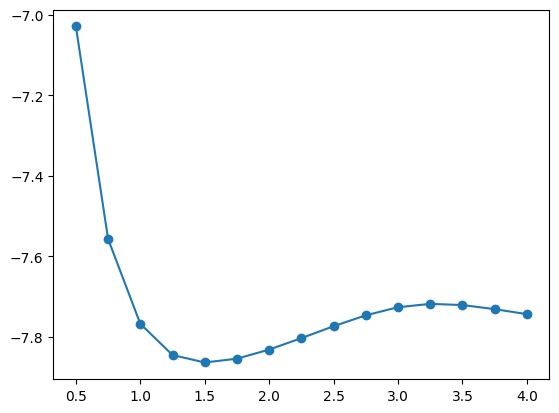

In [17]:

from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper

distancias = np.arange(0.5, 4.25, 0.25)
energias = np.zeros(len(distancias))

for i, d in enumerate(distancias): 
    
    # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
    driver = PySCFDriver(atom=["Li",f"H 1 {d}"], basis="sto-3g") 
    problema = driver.run()

    # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
    # En este caso se considera que los obitales 4 y 5 estan no activos
    fc_transformer = ActiveSpaceTransformer(2, num_spatial_orbitals=2)

    problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

        #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))


        # Acà sigue todo igual
    ansatz = UCCSD(problem.num_spatial_orbitals,
                   problem.num_particles,
                   mapper,
                   initial_state=HartreeFock(
                       problem.num_spatial_orbitals,
                       problem.num_particles,
                       mapper,),
    )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problem)

    energias[i] = result.total_energies[0] 

plt.scatter(distancias[:], energias[:])
plt.plot(distancias[:], energias[:])

minimo = np.min(energias)
numero = np.where(energias == minimo)
d_min = distancias[numero]
print(d_min)


## Reaciones de isomerización

Durante la siguiente secciòn intentarè abordar el tema de las reacciones de isomerización, para esto intentaré simular la molecula $C_4H_8$.


In [ ]:
def transformacion_eVolt(energia):
    ev = energia

In [25]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_algorithms import VQE 
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import  QuantumCircuit 
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt



# Esta matriz esta bien construida 
z_matrix_trans = [
    "C",
    "C 1 1.32258",
    "C 1 1.49321 2 125.14544",
    "H 1 1.08750 3 116.30975 2 180.00",
    "C 2 1.49321 1 125.14544 4 0.00",
    "H 2 1.08750 5 116.30975 1 180.00",
    "H 3 1.09249 1 111.16863 4 59.38997",
    "H 3 1.09249 7 108.12 1 -122.48",
    "H 3 1.09249 7 106.75 8 -116.12",
    "H 5 1.09249 2 111.17 6 59.39",
    "H 5 1.09249 10 108.12 2 -122.48",
    "H 5 1.09249 10 106.75 11 -116.12"
]

z_matrix_cis = [
    "C",
    "C 1 1.32258",
    "C 1 1.49321 2 125.14544",
    "H 1 1.08750 3 116.30975 2 180.00",
    "C 2 1.49321 1 125.14544 4 180.00",
    "H 2 1.08750 5 116.30975 1 180.00",
    "H 3 1.09249 1 111.16863 4 59.38997",
    "H 3 1.09249 7 108.12 1 -122.48",
    "H 3 1.09249 7 106.75 8 -116.12",
    "H 5 1.09249 2 111.17 6 59.39",
    "H 5 1.09249 10 108.12 2 -122.48",
    "H 5 1.09249 10 106.75 11 -116.12"
]

matrices = [z_matrix_trans, z_matrix_cis]
resultados = []

for i in matrices:
    
    driver = PySCFDriver(i, basis="sto-3g")

    problema = driver.run()

    fc_transformer = ActiveSpaceTransformer(2,2)

    problem = fc_transformer.transform(problema)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    ansatz = UCCSD(problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,
                    initial_state=HartreeFock(
                        problem.num_spatial_orbitals,
                        problem.num_particles,
                        mapper,),
        )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problem)
    resultados.append(result)
print(f"La energìa del trans-2-butene es {resultados[0].total_energies[0] } y la energìa del cis-2-butene es {resultados[1].total_energies[0]}")

La energìa del trans-2-butene es -154.27503126952496 y la energìa del cis-2-butene es -154.27076075596705


Se logra ver que la energìa son iguales, sin embargo al analizar los resultados por separados se obtiene lo siguiente:

In [70]:
abs(-154.27503126952496 - (-154.27076075596727))*27.211

0.11620494441817368

In [22]:
print(resultados[0])

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -270.600672315534
  - computed part:      -1.054582508683
  - ActiveSpaceTransformer extracted energy part: -269.546089806851
~ Nuclear repulsion energy (Hartree): 116.325641046009
> Total ground state energy (Hartree): -154.275031269525
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [39.98900159  -0.00017167  -0.00001609]
 
  0: 
  * Electronic dipole moment (a.u.): [39.989003893279  -0.000163361301  -0.000016048399]
    - computed part:      [2.4993139533  -0.000026416663  -0.000000864958]
    - ActiveSpaceTransformer extracted energy part: [37.489689939979  -0.000136944638  -0.00001518344]
  > Dipole moment (a.u.): [-0.000002303279  -0.000008308699  -0.000000041601]  Total: 0.000008622141
                 (debye): [-0.000005854352  -0.000021118605  -0.00000010574]  Total: 0.000021915293
 


In [23]:
print(resultados[1])

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -273.129565750498
  - computed part:      -1.056230803185
  - ActiveSpaceTransformer extracted energy part: -272.073334947313
~ Nuclear repulsion energy (Hartree): 118.858804994531
> Total ground state energy (Hartree): -154.270760755967
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [39.98900159  -0.00004612  41.54464372]
 
  0: 
  * Electronic dipole moment (a.u.): [39.989004444457  -0.000044144975  41.478921294148]
    - computed part:      [2.499313968115  -0.000006450915  0.648096995087]
    - ActiveSpaceTransformer extracted energy part: [37.489690476342  -0.00003769406  40.830824299061]
  > Dipole moment (a.u.): [-0.000002854457  -0.000001975025  0.065722425852]  Total: 0.065722425944
                 (debye): [-0.000007255306  -0.000005020012  0.167049728206]  Total: 0.167049728439
 


Por lo tanto, tiene cambios en la energía del espacio activo y en la energia de repulsiòn

La idea es ahora parametrizar el angulo del carbono que rota cuando se hace la reacción de isomerización

In [5]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_algorithms import VQE 
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import  QuantumCircuit 
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt


theta = np.linspace(5, 180, 30) #El angulo va desde 0 hasta 180 

energia_total = np.zeros(len(theta))
energia_elect = np.zeros(len(theta))
nuclear_repulsion_energies = np.zeros(len(theta))


for j, angle in enumerate(theta): 

    z_matrix= [
        "C",
        f"C 1 1.32258",
        "C 1 1.49321 2 125.14544",
        "H 1 1.08750 3 116.30975 2 180.00",
        f"C 2 1.49321 1 125.14544 4 {angle}",
        "H 2 1.08750 5 116.30975 1 180.00",
        "H 3 1.09249 1 111.16863 4 59.39",
        "H 3 1.09249 7 108.12 1 -122.48",
        "H 3 1.09249 7 106.75 8 -116.12",
        "H 5 1.09249 2 111.17 6 59.39",
        "H 5 1.09249 10 108.12 2 -122.48",
        "H 5 1.09249 10 106.75 11 -116.12"
    ]

    # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
    driver = PySCFDriver(atom=z_matrix, basis="sto-3g") 
    problema = driver.run()

    # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
    # En este caso se considera que los obitales 4 y 5 estan no activos
    fc_transformer = ActiveSpaceTransformer(2, 2)

    problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

        #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    ansatz = UCCSD(problem.num_spatial_orbitals,
                problem.num_particles,
                mapper,
                initial_state=HartreeFock(
                    problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,),
    )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problem)

    energia_total[j] = result.total_energies[0]*627.51 
    energia_elect[j] = result.electronic_energies[0]
    nuclear_repulsion_energies[j] = result.nuclear_repulsion_energy

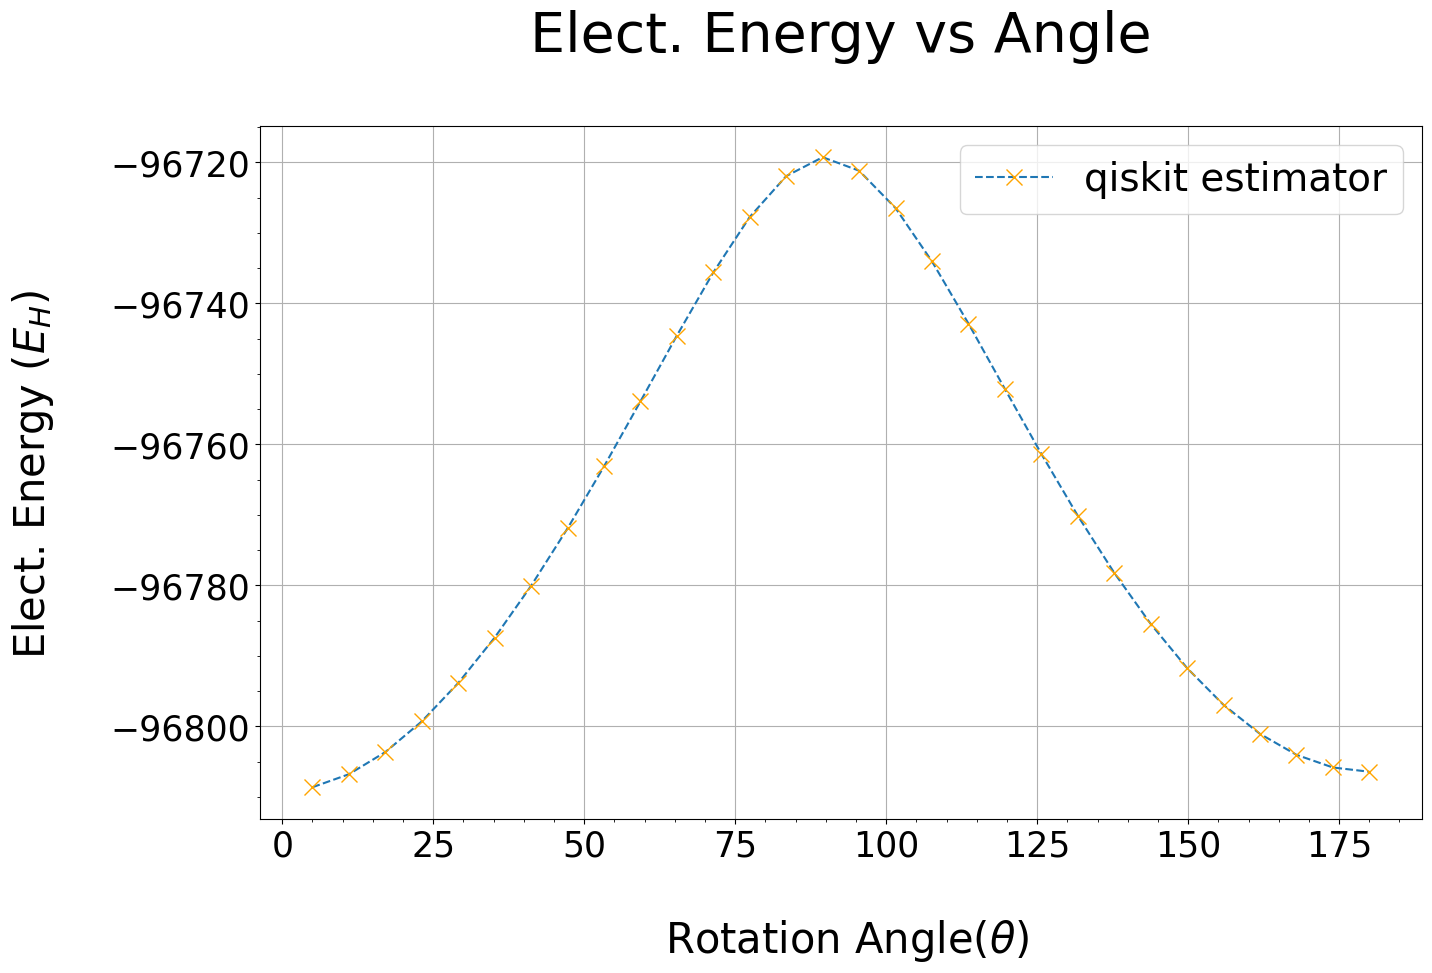

In [9]:
plt.figure(figsize=(15, 9))
plt.errorbar(theta, energia_total, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange', markersize= 12 )
plt.xlabel('\n Rotation Angle'+r'($\theta$)', fontsize= 30 )
plt.ylabel('Elect. Energy ($E_H$) \n', fontsize= 30)
plt.title('Elect. Energy vs Angle\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

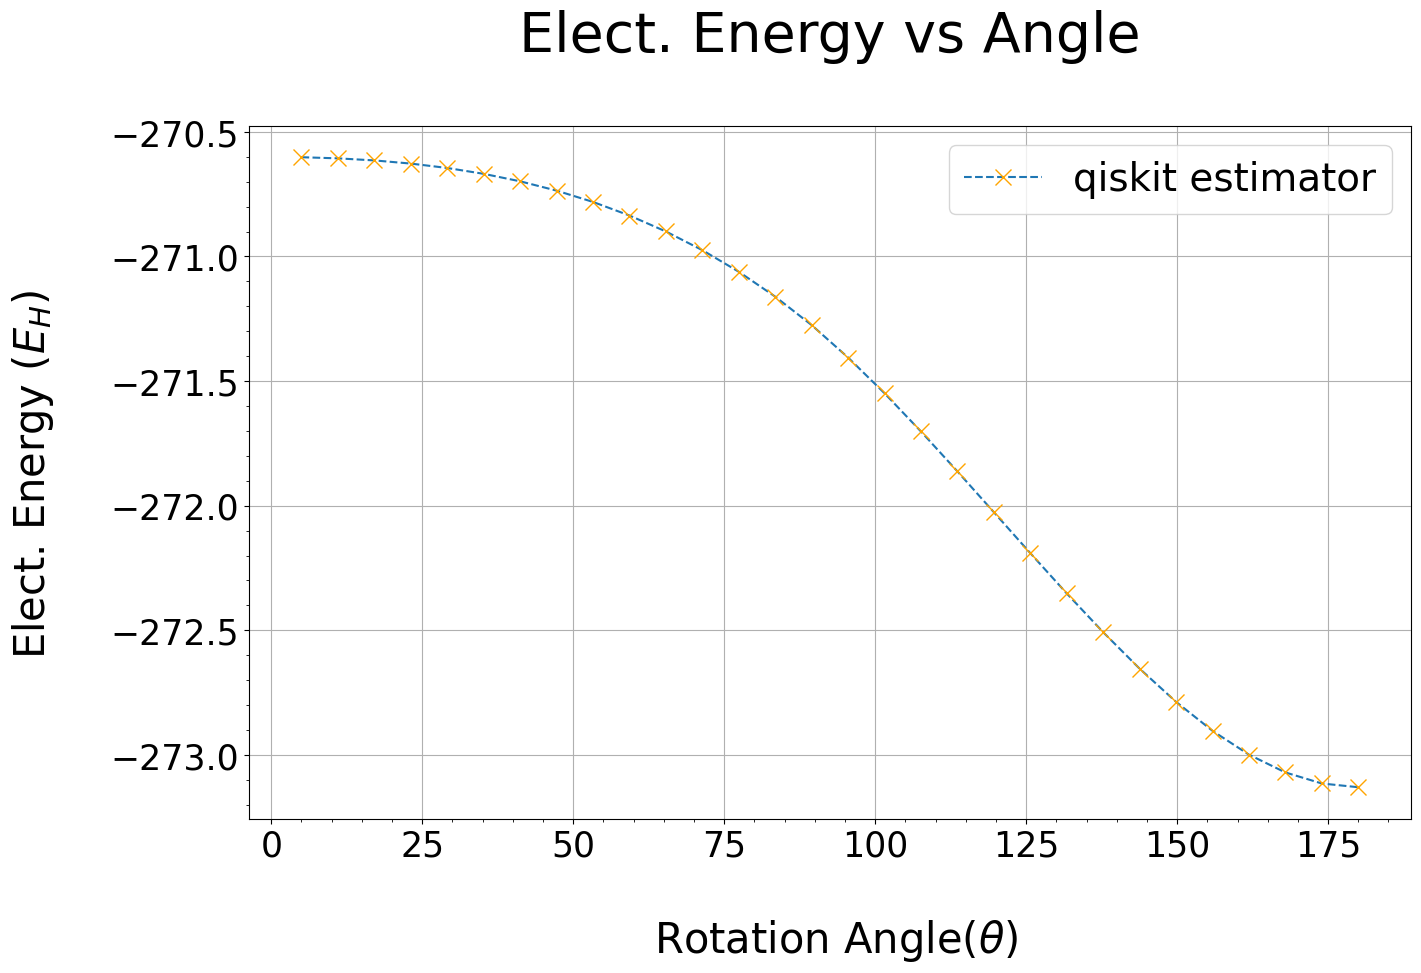

In [10]:
plt.figure(figsize=(15, 9))
plt.errorbar(theta, energia_elect, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange', markersize= 12 )
plt.xlabel('\n Rotation Angle'+r'($\theta$)', fontsize= 30 )
plt.ylabel('Elect. Energy ($E_H$) \n', fontsize= 30)
plt.title('Elect. Energy vs Angle\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()


En El gráfico anterior se logra ver claramente el cambio de la fase trans a la cis (Vamooo)

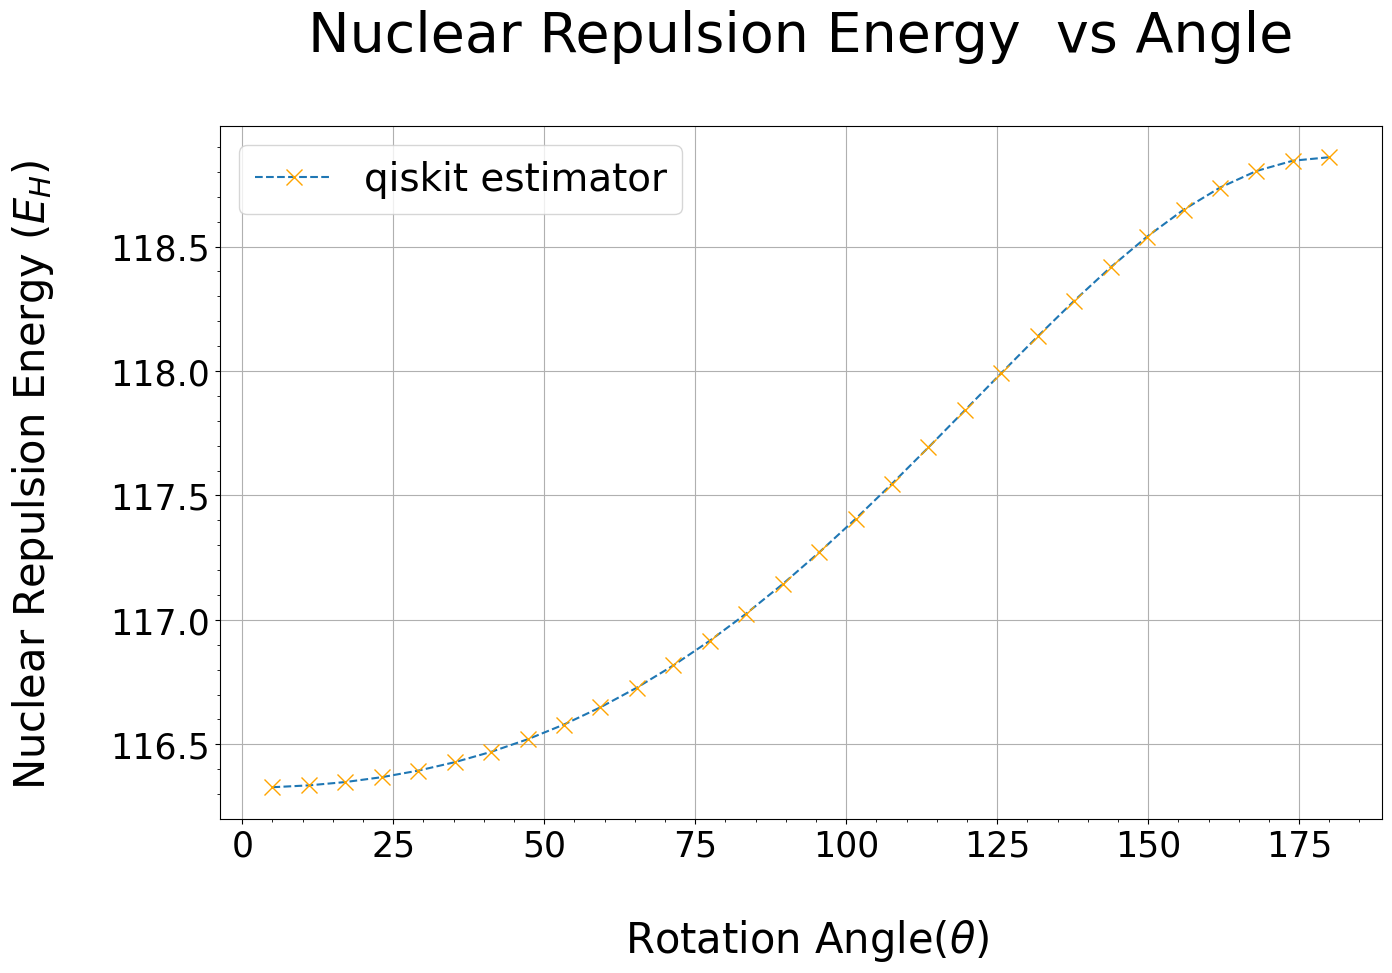

In [11]:
plt.figure(figsize=(15, 9))
plt.errorbar(theta, nuclear_repulsion_energies, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange', markersize= 12 )
plt.xlabel('\n Rotation Angle'+r'($\theta$)', fontsize= 30 )
plt.ylabel('Nuclear Repulsion Energy ($E_H$) \n', fontsize= 30)
plt.title('Nuclear Repulsion Energy  vs Angle\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

Ahora intentaré representar el cambio en la distancia intermolecular de los carbonos que tiene el enlace doble. Esto es para intentar simular el efecto de la polarizaciòn en los enlaces de la molecula.

In [17]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_algorithms import VQE 
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import  QuantumCircuit 
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

dis = np.linspace(1.32258-0.2, 1.32258+0.5, 20) # la distancia intermolecular v
theta = np.linspace(5, 180, 20) #El angulo va desde 0 hasta 180 particionado 20 veces

energia_total = np.zeros((len(theta), len(dis)))


for i, distancia in enumerate(dis):
    for j, angle in enumerate(theta): 

        z_matrix= [
            "C",
            f"C 1 {distancia}",
            "C 1 1.49321 2 125.14544",
            "H 1 1.08750 3 116.30975 2 180.00",
            f"C 2 1.49321 1 125.14544 4 {angle}",
            "H 2 1.08750 5 116.30975 1 180.00",
            "H 3 1.09249 1 111.16863 4 59.39",
            "H 3 1.09249 7 108.12 1 -122.48",
            "H 3 1.09249 7 106.75 8 -116.12",
            "H 5 1.09249 2 111.17 6 59.39",
            "H 5 1.09249 10 108.12 2 -122.48",
            "H 5 1.09249 10 106.75 11 -116.12"
        ]

        # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
        driver = PySCFDriver(atom=z_matrix, basis="sto-3g") 
        problema = driver.run()

        # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
        # En este caso se considera que los obitales 4 y 5 estan no activos
        fc_transformer = ActiveSpaceTransformer(2, 2)

        problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

            #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
        mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

        ansatz = UCCSD(problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,
                    initial_state=HartreeFock(
                        problem.num_spatial_orbitals,
                        problem.num_particles,
                        mapper,),
        )
        vqe = VQE(Estimator(), ansatz, SLSQP())

        initial_point = HFInitialPoint()
        initial_point.ansatz = ansatz
        initial_point.problem = problem
        vqe.initial_point = initial_point.to_numpy_array()
        solver = GroundStateEigensolver(mapper, vqe)
        result = solver.solve(problem)

        energia_total[i,j] = result.total_energies[0]*627.51 

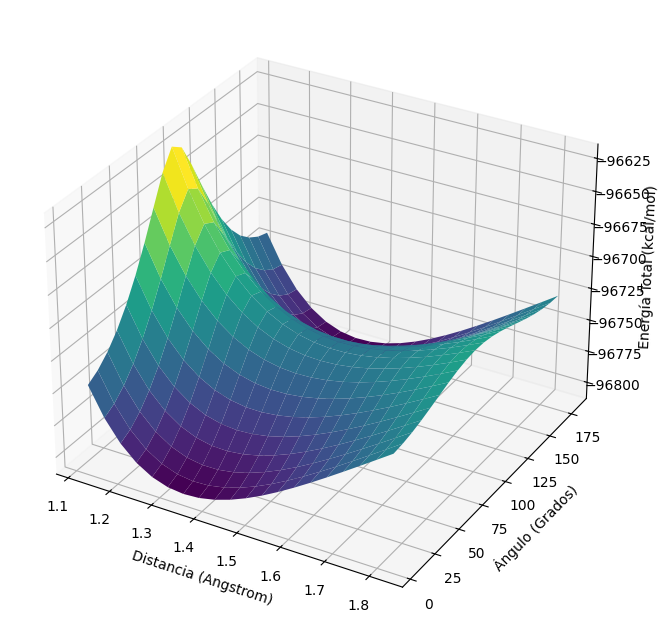

In [18]:

# Generación del gráfico 3D
X, Y = np.meshgrid(dis, theta)
Z = energia_total.T  # Transpuesta para alinear correctamente los datos

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Distancia (Angstrom)')
ax.set_ylabel('Ángulo (Grados)')
ax.set_zlabel('Energía Total (kcal/mol)')
plt.show()

# Enter player 2!:



In [6]:
#importamos las librerias necesarias

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_algorithms import VQE 
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import  QuantumCircuit 
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt



# Esta matriz esta bien construida 
z_matrix_trans = [
    "C",
    "C 1 1.32258",
    "C 1 1.49321 2 125.14544",
    "H 1 1.08750 3 116.30975 2 180.00",
    "C 2 1.49321 1 125.14544 4 0.00",
    "H 2 1.08750 5 116.30975 1 180.00",
    "H 3 1.09249 1 111.16863 4 59.38997",
    "H 3 1.09249 7 108.12 1 -122.48",
    "H 3 1.09249 7 106.75 8 -116.12",
    "H 5 1.09249 2 111.17 6 59.39",
    "H 5 1.09249 10 108.12 2 -122.48",
    "H 5 1.09249 10 106.75 11 -116.12"
]

z_matrix_cis = [
    "C",
    "C 1 1.32258",
    "C 1 1.49321 2 125.14544",
    "H 1 1.08750 3 116.30975 2 180.00",
    "C 2 1.49321 1 125.14544 4 180.00",
    "H 2 1.08750 5 116.30975 1 180.00",
    "H 3 1.09249 1 111.16863 4 59.38997",
    "H 3 1.09249 7 108.12 1 -122.48",
    "H 3 1.09249 7 106.75 8 -116.12",
    "H 5 1.09249 2 111.17 6 59.39",
    "H 5 1.09249 10 108.12 2 -122.48",
    "H 5 1.09249 10 106.75 11 -116.12"
]

matrices = [z_matrix_trans, z_matrix_cis]
resultados = []

for i in matrices:
    
    driver = PySCFDriver(i, basis="6-31g")

    problema = driver.run()

    fc_transformer = ActiveSpaceTransformer(2,2)

    problem = fc_transformer.transform(problema)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    ansatz = UCCSD(problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,
                    initial_state=HartreeFock(
                        problem.num_spatial_orbitals,
                        problem.num_particles,
                        mapper,),
        )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problem)
    resultados.append(result)
print(f"La energìa del trans-2-butene es {resultados[0].total_energies[0] } y la energìa del cis-2-butene es {resultados[1].total_energies[0]}")
print(f'DeltaE = {np.abs(resultados[0].total_energies[0] - resultados[1].total_energies[0])}')

La energìa del trans-2-butene es -156.06582156328636 y la energìa del cis-2-butene es -156.06104509144086
DeltaE = 0.004776471845502783


In [7]:
#generemos una función que nos ejecute el algoritmo de VQE
# y que nos entregue el estado final, la energia y el hamiltoniano utilziado

def generate_vqe_optimal(z_matrix : list, active_electrons : int):

    driver = PySCFDriver(z_matrix, basis="6-31g") #inicializamos el problema

    problema = driver.run()
    fc_transformer = ActiveSpaceTransformer(active_electrons, active_electrons)
    problem = fc_transformer.transform(problema) #problema reducido
    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta)) #le aplicamos el mapper de paridad}

    hamiltonian = problem.hamiltonian.second_q_op()
    pauli_hamiltonian = mapper.map(hamiltonian)

    ansatz = UCCSD(problem.num_spatial_orbitals,
                    problem.num_particles,
                    mapper,
                    initial_state=HartreeFock(
                        problem.num_spatial_orbitals,
                        problem.num_particles,
                        mapper,),
        ) #nuestro ansatz
    
    vqe = VQE(Estimator(), ansatz, SLSQP()) #VQE

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problem)
    resultados.append(result)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz, pauli_hamiltonian




In [8]:
gs_energy, optimal_ansatz, pauli_ham = generate_vqe_optimal(z_matrix= z_matrix_cis,
                                                             active_electrons= 2)

In [9]:
print(gs_energy)

-156.0610450914442


## Analizemos como se ve el estado final:

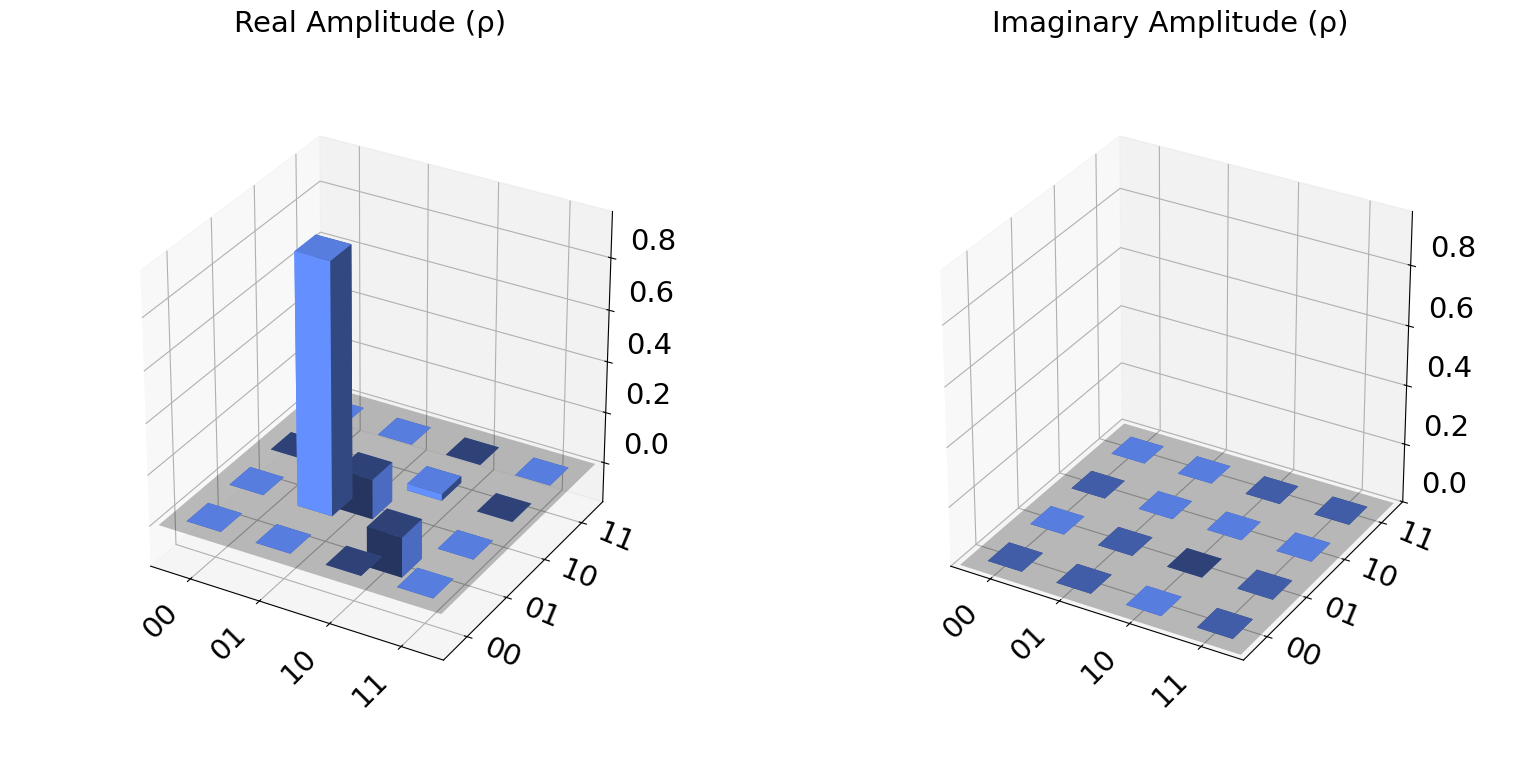

In [10]:
from qiskit.quantum_info import Statevector

Statevector(optimal_ansatz).draw('city')

In [11]:
from qiskit.quantum_info import entanglement_of_formation

#just a liltle bit of entanglement...

print(entanglement_of_formation(Statevector(optimal_ansatz)))

0.17216072797535698


In [12]:
Statevector(optimal_ansatz).draw('latex')

<IPython.core.display.Latex object>

/tmp/ipykernel_7201/2762301239.py:14: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(backend= backend)


Expectation values: -1.0829022933647239
E_constant: 144.11368970928862


In [13]:

#Parametrizaremos a la molecula tal que solo con ingresar las coordenadas
#de reacciones, podramos describir esta molécula...
def z_matrix_generator(alpha = 0, pi_bond_distance = 1.32258):
    z_matrix = [
                "C",
                f"C 1 {pi_bond_distance}",
                "C 1 1.49321 2 125.14544",
                "H 1 1.08750 3 116.30975 2 180.00",
                f"C 2 1.49321 1 125.14544 4 {alpha}",
                "H 2 1.08750 5 116.30975 1 180.00",
                "H 3 1.09249 1 111.16863 4 59.39",
                "H 3 1.09249 7 108.12 1 -122.48",
                "H 3 1.09249 7 106.75 8 -116.12",
                "H 5 1.09249 2 111.17 6 59.39",
                "H 5 1.09249 10 108.12 2 -122.48",
                "H 5 1.09249 10 106.75 11 -116.12"
                ]
    return z_matrix

In [14]:
cis_z_matrix = z_matrix_generator(alpha= 180)
trans_z_matrix = z_matrix_generator(alpha= 0)


# Lets first evolution thought the trans-state

The reason because we are doing this is to see if there is an evolution throught time 
in the final state found with the VQE algorithm, and to see if it stays in the groundstate

This will be describe if it really is a ground state it should not evolution in time at all:

In [18]:
trans_gs_energy, trans_gs_circuit, trans_pauli_ham = generate_vqe_optimal(z_matrix_trans, 2)

In [26]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager



backend = AerSimulator()

pm = generate_preset_pass_manager(backend= backend,
                                  optimization_level= 1)

trans_isa_optimal_ansatz = pm.run(trans_gs_circuit)
trans_isa_hamiltonian = pauli_ham.apply_layout(trans_isa_optimal_ansatz.layout)

estimator = EstimatorV2(backend= backend)

job = estimator.run([(trans_isa_optimal_ansatz, trans_isa_hamiltonian)])
pub_result = job.result()[0]

#energy
print(f"Expectation values: {pub_result.data.evs}")

trans_energy_constant = -154.27503126952496 / pub_result.data.evs

print(f'E_constant: {trans_energy_constant}')

/tmp/ipykernel_7201/3262967983.py:15: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(backend= backend)


Expectation values: -1.0802542933700698
E_constant: 142.8136247329627


In [41]:
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter


final_time = 100
time_steps = 1000

dt = final_time / time_steps

trotter = TrotterQRTE(product_formula= SuzukiTrotter(4),
                      num_timesteps= time_steps,
                      estimator= Estimator())

initial_state = Statevector(trans_gs_circuit)

problem = TimeEvolutionProblem(hamiltonian= trans_pauli_ham,
                               initial_state= initial_state,
                               time= final_time,
                               aux_operators= [trans_pauli_ham])

result = trotter.evolve(problem)



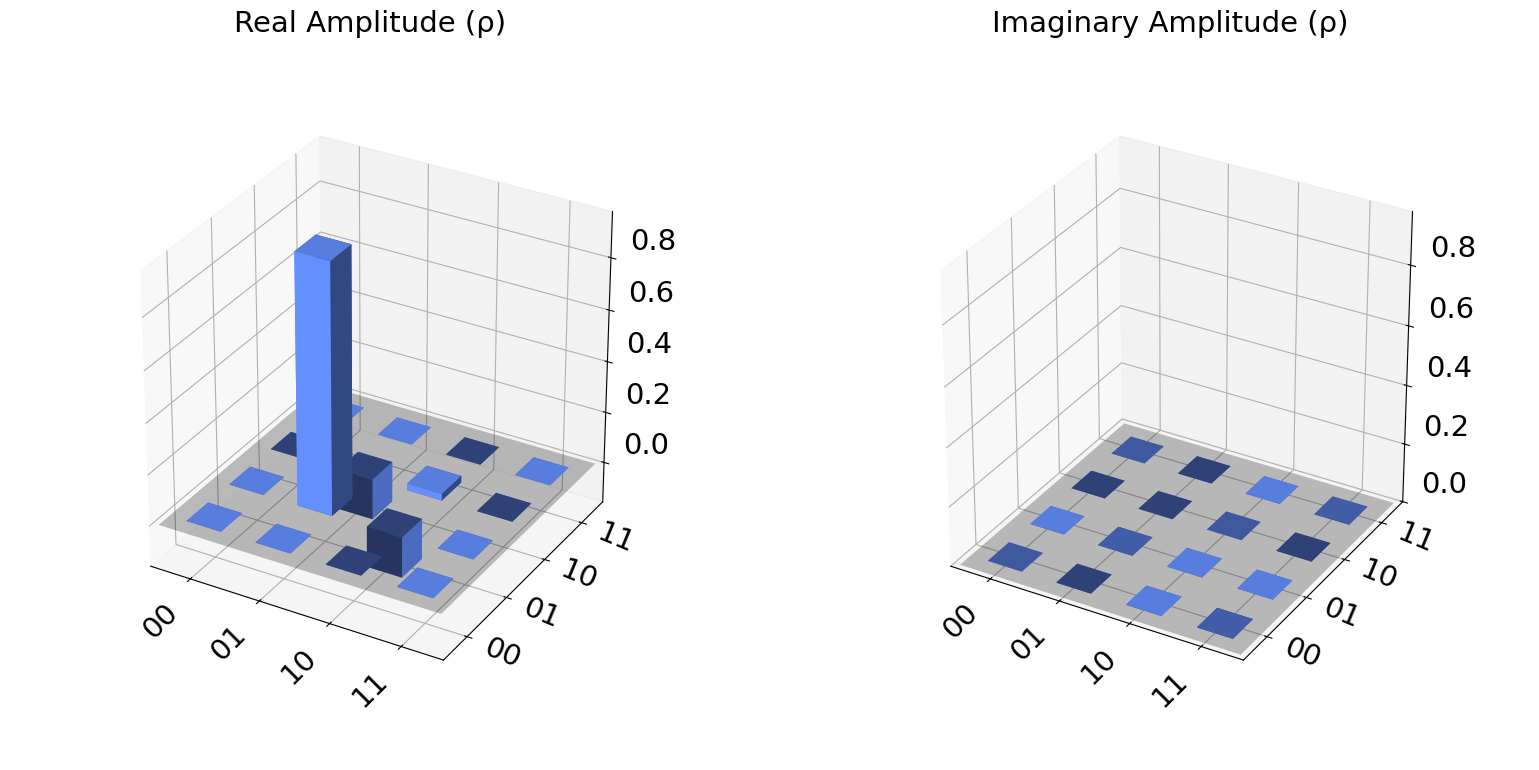

In [42]:
final_state = result.evolved_state

obs_data = np.array((np.array(result.observables)[:,:,0]))

energies = obs_data[:, 0]


Statevector(final_state).draw('city')

1001
1001


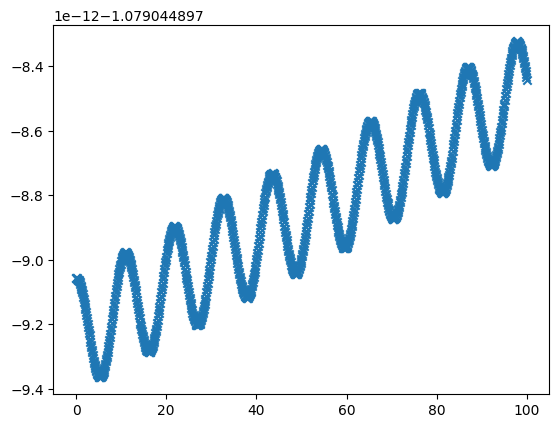

In [44]:
import matplotlib.pyplot as plt

times = np.linspace(0, final_time, time_steps + 1)


print(len(times))
print(len(energies))

plt.scatter(times, energies, marker= 'x')
plt.show()

In [20]:
cis_gs_energy, cis_gs_circuit, cis_pauli_ham = generate_vqe_optimal(z_matrix_cis, 2)

In [27]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager



backend = AerSimulator()

pm = generate_preset_pass_manager(backend= backend,
                                  optimization_level= 1)

cis_isa_optimal_ansatz = pm.run(cis_gs_circuit)
cis_isa_hamiltonian = pauli_ham.apply_layout(cis_isa_optimal_ansatz.layout)

estimator = EstimatorV2(backend= backend)

job = estimator.run([(cis_isa_optimal_ansatz, cis_isa_hamiltonian)])
pub_result = job.result()[0]

#energy
print(f"Expectation values: {pub_result.data.evs}")

cis_energy_constant = -154.27076075596705 / pub_result.data.evs

print(f'E_constant: {cis_energy_constant}')

/tmp/ipykernel_7201/3052469956.py:15: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(backend= backend)


Expectation values: -1.081959875934834
E_constant: 142.58454882411806


In [47]:
final_time = 100
time_steps = 1000

dt = final_time / time_steps

trotter = TrotterQRTE(product_formula= SuzukiTrotter(4),
                      num_timesteps= time_steps,
                      estimator= Estimator())

initial_state = Statevector(cis_gs_circuit)

problem = TimeEvolutionProblem(hamiltonian= cis_pauli_ham,
                               initial_state= initial_state,
                               time= final_time,
                               aux_operators= [cis_pauli_ham])

result = trotter.evolve(problem)


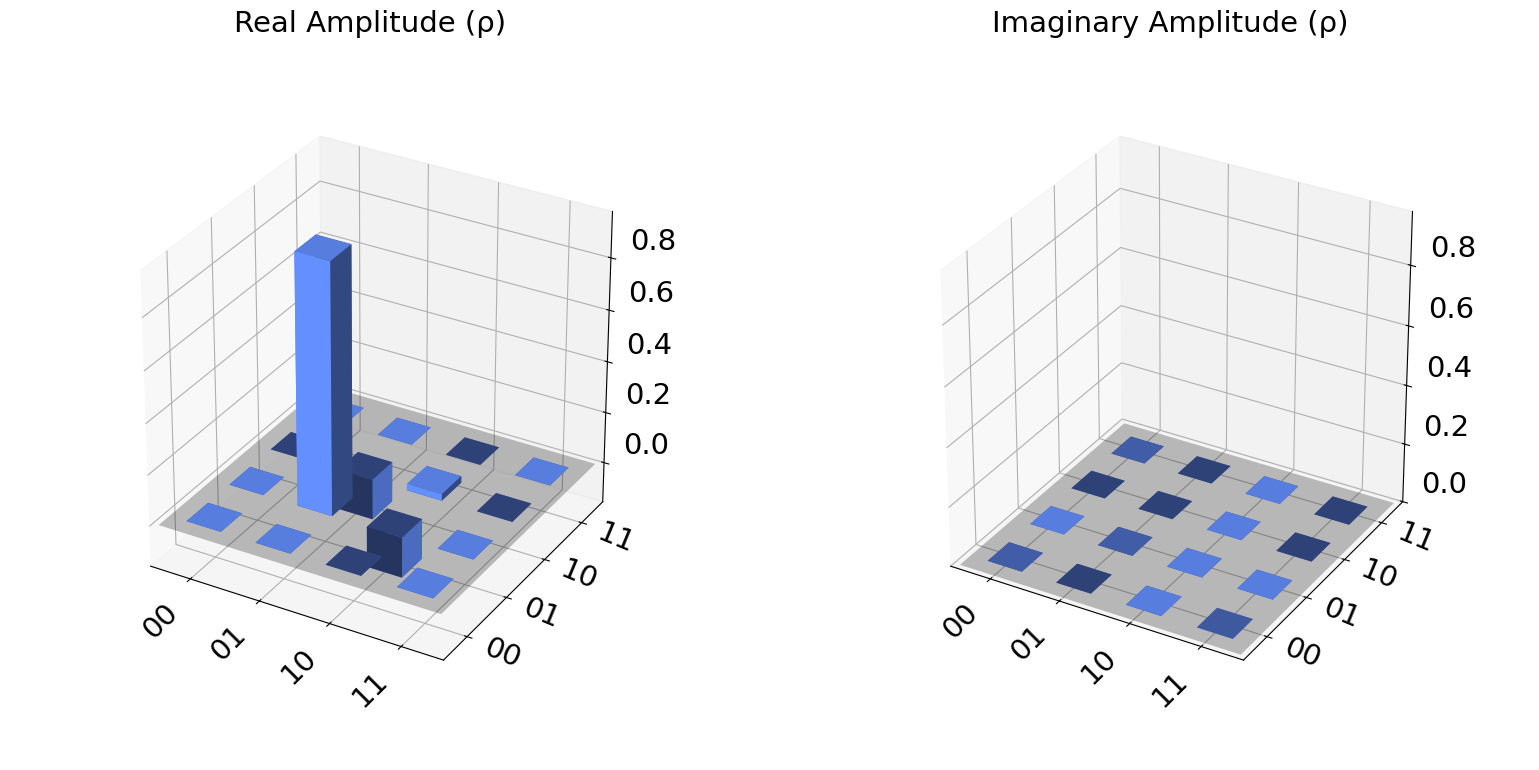

In [48]:
cis_final_state = result.evolved_state

cis_obs_data = np.array((np.array(result.observables)[:,:,0]))

cis_energies = cis_obs_data[:, 0]


Statevector(cis_final_state).draw('city')

1001
1001


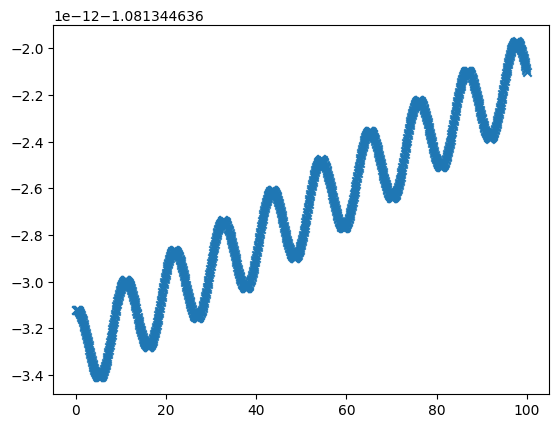

In [49]:
import matplotlib.pyplot as plt

times = np.linspace(0, final_time, time_steps + 1)


print(len(times))
print(len(energies))

plt.scatter(times, cis_energies, marker= 'x')
plt.show()

## Discussion

As we can see, it is seem that there is not a certain evolution in time (as you can see in the plot, the energy as a function of time remains the same)

In [31]:
print(cis_energy_constant)
print(trans_energy_constant)

print(f'{(cis_energy_constant - trans_energy_constant)/cis_energy_constant * 100}')



142.58454882411806
142.8136247329627
-0.16065970032082957


In [33]:
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter




final_time = 2
time_steps = 500

dt = final_time / time_steps

trotter = TrotterQRTE(product_formula= SuzukiTrotter(4),
                      num_timesteps= time_steps,
                      estimator= Estimator())

initial_state = Statevector(cis_gs_circuit)

problem = TimeEvolutionProblem(hamiltonian= cis_pauli_ham,
                               initial_state= initial_state,
                               time= final_time,
                               aux_operators= [cis_pauli_ham])

result = trotter.evolve(problem)

In [38]:
cis_final_state = result.evolved_state


backend = AerSimulator()

pm = generate_preset_pass_manager(backend= backend,
                                  optimization_level= 1)

cis_isa_optimal_ansatz = pm.run(cis_final_state)
cis_isa_hamiltonian = pauli_ham.apply_layout(cis_isa_optimal_ansatz.layout)

estimator = EstimatorV2(backend= backend)

job = estimator.run([(cis_isa_optimal_ansatz, cis_isa_hamiltonian)])
pub_result = job.result()[0]

#energy
print(f"Expectation values: {pub_result.data.evs * cis_energy_constant}")




/tmp/ipykernel_7201/203235474.py:12: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(backend= backend)


Expectation values: -154.5320031486979
